In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  , ConfusionMatrixDisplay , classification_report , f1_score , precision_score , recall_score , confusion_matrix
import seaborn as sns
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import io

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron , LogisticRegression
import pickle
import random

from prettytable import PrettyTable
from tabulate import tabulate

In [3]:
categories = ['jogging' , 
              'sitting' , 
              'standing' , 
              'walking']

data_directory = '/mnt/d/CV_project_phase_1/Dataset_images/'

In [4]:
image_size = (256, 256)
dataset = []
labels = []

for category in categories:
    folder_path = os.path.join(data_directory, category)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = load_img(image_path, target_size=image_size)
        image_array = img_to_array(image)
        dataset.append(image_array)
        labels.append(categories.index(category))

dataset = np.array(dataset)
dataset = dataset.astype(np.uint8)
labels = np.array(labels)

In [5]:
def extract_lbp_features(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute LBP feature
    radius = 1  # LBP neighborhood radius
    n_points = 8 * radius  # Number of points to sample on the LBP circle
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')

    # Calculate the histogram of LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # Return the LBP histogram as feature vector
    return hist

In [6]:
# Initialize an empty list to store the LBP features
lbp_features = []

# Iterate over each image in the dataset and extract LBP features
for image in dataset:
    lbp_features.append(extract_lbp_features(image))

# Convert the features list to a numpy array
lbp_features = np.array(lbp_features)

In [7]:
lbp_features.shape

(2584, 10)

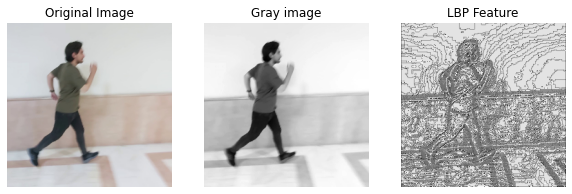

In [9]:
### sample visualization of LBP features

sample = dataset[91]

def visualize_lbp(image):

    gray_image = cv2.cvtColor(image , cv2.COLOR_RGB2GRAY)
   

    # Compute LBP feature
    radius = 1  # LBP neighborhood radius
    n_points = 8 * radius  # Number of points to sample on the LBP circle
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')

    # Display the image and LBP feature side by side
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(gray_image, cmap ='gray')
    axes[1].set_title('Gray image')
    axes[1].axis('off')

    axes[2].imshow(lbp, cmap='gray')
    axes[2].set_title('LBP Feature')
    axes[2].axis('off')

    plt.show()

LBP_image = visualize_lbp(sample)



In [10]:
## KNN with standard scaling

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(lbp_features, labels, test_size=0.2, random_state=42)


k = 10  
knn = KNeighborsClassifier(n_neighbors=k)

## Scaling the data
scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.transform(X_test_1)
knn.fit(X_train_1, y_train_1)

# Predict on the test set
y_pred = knn.predict(X_test_1)

report = classification_report(y_test_1, y_pred)

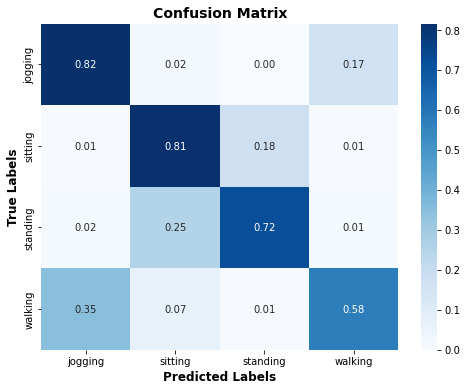

In [11]:
class_names = ['jogging' , 
              'sitting' , 
              'standing' , 
              'walking']
# Create confusion matrix
cm = confusion_matrix(y_test_1, y_pred)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize the heatmap colors
cmap = 'Blues'  # Change the color palette here

# Plot the heatmap
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap=cmap, xticklabels=class_names, yticklabels=class_names, ax=ax)

# Customize labels and title
ax.set_xlabel('Predicted Labels', fontsize=12, fontweight='bold')
ax.set_ylabel('True Labels', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.show()


In [12]:
print (report)

              precision    recall  f1-score   support

           0       0.73      0.82      0.77       114
           1       0.79      0.81      0.80       185
           2       0.73      0.72      0.73       126
           3       0.72      0.58      0.64        92

    accuracy                           0.75       517
   macro avg       0.74      0.73      0.73       517
weighted avg       0.75      0.75      0.75       517



In [13]:

report = classification_report(y_test_1, y_pred, target_names=class_names, output_dict=True)

# Create a pretty table
table = PrettyTable()
table.field_names = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support']

# Add rows to the table
for class_name, scores in report.items():
    if class_name in class_names:
        precision = scores['precision']
        recall = scores['recall']
        f1_score = scores['f1-score']
        support = scores['support']
        table.add_row([class_name, precision, recall, f1_score, support])

# Set alignment and format for numeric columns
table.align['Class'] = 'l'
table.align['Precision'] = 'f'
table.align['Recall'] = 'f'
table.align['F1-Score'] = 'f'
table.align['Support'] = 'c'

# Print the styled classification report
print(table)

+----------+--------------------+--------------------+--------------------+---------+
| Class    |     Precision      |       Recall       |      F1-Score      | Support |
+----------+--------------------+--------------------+--------------------+---------+
| jogging  |     0.7265625      | 0.8157894736842105 | 0.7685950413223139 |   114   |
| sitting  | 0.7894736842105263 | 0.8108108108108109 |        0.8         |   185   |
| standing |       0.728        | 0.7222222222222222 | 0.7250996015936256 |   126   |
| walking  | 0.7162162162162162 | 0.5760869565217391 | 0.6385542168674698 |    92   |
+----------+--------------------+--------------------+--------------------+---------+


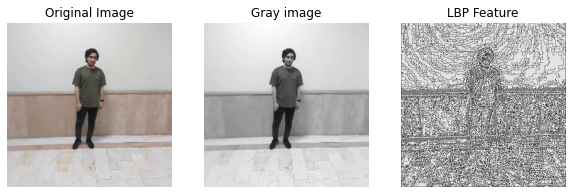

In [14]:
sample = dataset[1505]
LBP_image = visualize_lbp(sample)


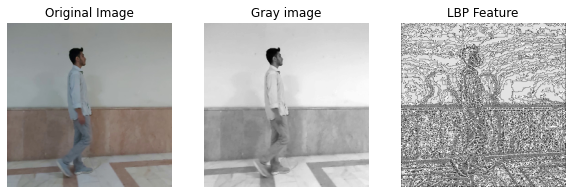

In [15]:
sample = dataset[2550]
LBP_image = visualize_lbp(sample)


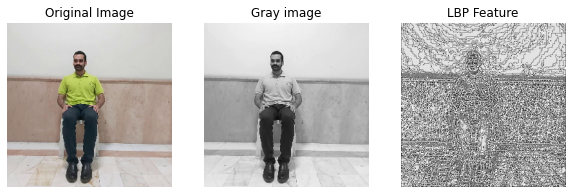

In [16]:
sample = dataset[850]
LBP_image = visualize_lbp(sample)



In [17]:
# Save the model to a file
filename = 'knn_model_LBP.pkl'
with open(filename, 'wb') as file:
    pickle.dump(knn, file)